## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

### Инструкция по выполнению проекта

Откройте файл с данными и изучите его. Путь к файлу: /datasets/users_behavior.csv.

Разделите исходные данные на обучающую, валидационную и тестовую выборки.

Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.

Проверьте качество модели на тестовой выборке.

Дополнительное задание: проверьте модели на вменяемость. Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше. В следующем курсе подробнее об этом расскажем.

### Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

Импортирую необходимые библиотеки.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import seaborn as sbn 
import warnings
warnings.filterwarnings('ignore')

Открою файл с данными.

In [2]:
try:  
    behavior = pd.read_csv('C:/users_behavior.csv')
except OSError as e:
    behavior = pd.read_csv('/datasets/users_behavior.csv')
display(behavior.head(10))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Посмотрю на основные данные по таблице.

In [3]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


### Вывод

Таблица представляет собой предобработаные данные, со следующими столбцами:

- calls - количество звонков пользователя;
- minutes - количество минут разговоров;
- messages - количество отправленных смс;
- mb_used - количество использованных мегабайт;
- is_ultra - 1 в данной столбце означает, что пользователь пользовался тарифом ultra, 0 - тарифом smart.

Никаких действий по предобработке данных в таблице я не делаю, так как для данного проекта она не требует предобработки.

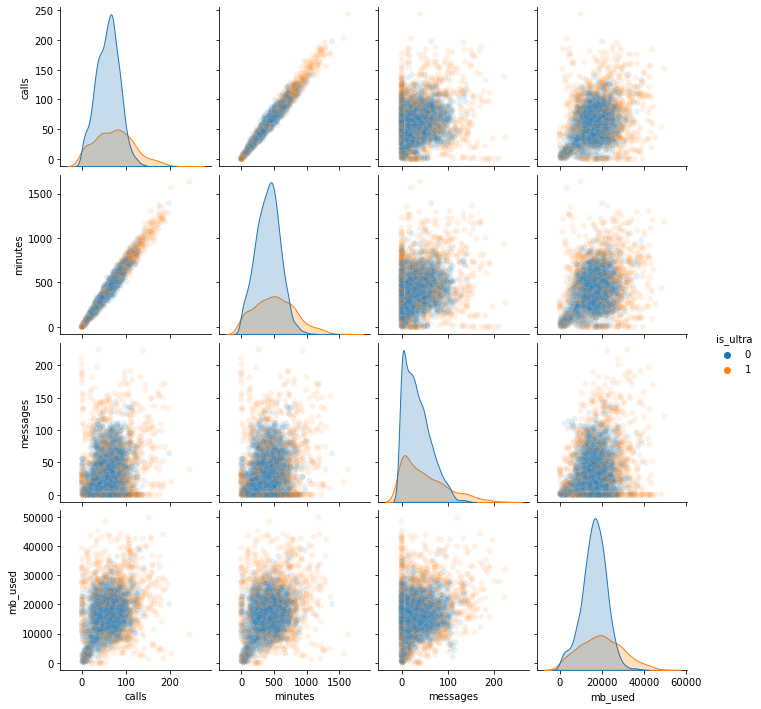

In [4]:
sbn.pairplot(behavior, hue = 'is_ultra', plot_kws={'alpha':0.1}) 
plt.show()

## Разбейте данные на выборки

Разобью данные на три выборки - обучающую, валидационную и тестовую в соотношении 60/20/20.

In [5]:
#отделю обучающую выборку
train_behavior, other_behavior = train_test_split(behavior, test_size=0.40, random_state=12345)
#разделю оставшиеся данные на валидационную и тестовую выборки
valid_behavior, test_behavior = train_test_split(other_behavior, test_size=0.50, random_state=12345)

print('Размер обучающей выборки', train_behavior.shape[0])
print('Размер валидационной выборки', valid_behavior.shape[0])
print('Размер тестовой выборки', test_behavior.shape[0])

Размер обучающей выборки 1928
Размер валидационной выборки 643
Размер тестовой выборки 643


Отделю от каждой выборки значимый столбец (is_ultra) в отдельную переменную.

In [7]:
train_behavior_features = train_behavior.drop(['is_ultra'], axis=1)
train_behavior_target = train_behavior['is_ultra']
valid_behavior_features = valid_behavior.drop(['is_ultra'], axis=1)
valid_behavior_target = valid_behavior['is_ultra']
test_behavior_features = test_behavior.drop(['is_ultra'], axis=1)
test_behavior_target = test_behavior['is_ultra']

### Вывод

Генералоьная совокупность разбита на три выборки в соотношении 60/20/20. Также из каждой выборки я в отдельную переменную выделил столбец is_ultra, так как в нем находится target наших выборок.

## Исследуйте модели

Так как я имею дело с классификацией, то проверю три модели - решающее дерево, случайный лес, логистическую регрессию.

### Решающее дерево

Найду лучшую модель решающего дерева.

In [8]:
#создам списки для построения графика
depth_graph = []
accuracy_draph = []
#найду лучший результат меняя глубину дерева
best_result = 0
best_depth = 0
for depth in range(1, 40):
    #чтобы зафиксировать псевдослучайность для алгоритма обучения укажу параметр random_state = 12345
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(train_behavior_features, train_behavior_target)
    predictions_valid = model_dtc.predict(valid_behavior_features)
    accuracy = accuracy_score(valid_behavior_target,  predictions_valid)
    depth_graph.append(depth)
    accuracy_draph.append(accuracy)
    if accuracy > best_result:
        best_result, best_depth = accuracy, depth
    print("max_depth =", depth, ": ", end='')
    #посмотрю на точность модели
    print(accuracy)
    
print(best_depth, best_result)

max_depth = 1 : 0.7542768273716952
max_depth = 2 : 0.7822706065318819
max_depth = 3 : 0.7853810264385692
max_depth = 4 : 0.7791601866251944
max_depth = 5 : 0.7791601866251944
max_depth = 6 : 0.7838258164852255
max_depth = 7 : 0.7822706065318819
max_depth = 8 : 0.7791601866251944
max_depth = 9 : 0.7822706065318819
max_depth = 10 : 0.7744945567651633
max_depth = 11 : 0.7620528771384136
max_depth = 12 : 0.7620528771384136
max_depth = 13 : 0.7558320373250389
max_depth = 14 : 0.7589424572317263
max_depth = 15 : 0.7465007776049767
max_depth = 16 : 0.7340590979782271
max_depth = 17 : 0.7356143079315708
max_depth = 18 : 0.7309486780715396
max_depth = 19 : 0.7278382581648523
max_depth = 20 : 0.7216174183514774
max_depth = 21 : 0.7278382581648523
max_depth = 22 : 0.7262830482115086
max_depth = 23 : 0.7169517884914464
max_depth = 24 : 0.713841368584759
max_depth = 25 : 0.713841368584759
max_depth = 26 : 0.713841368584759
max_depth = 27 : 0.713841368584759
max_depth = 28 : 0.713841368584759
max_de

Построю график для визуализации.

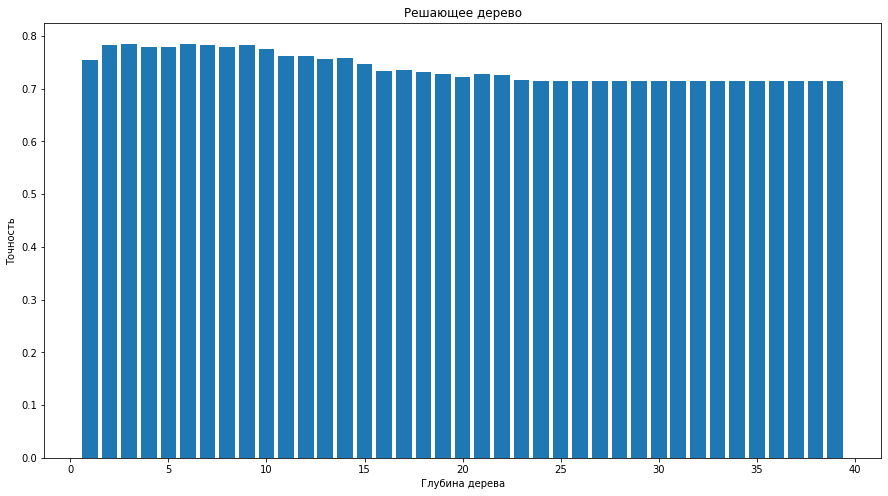

In [9]:
plt.figure(figsize=(15,8))
plt.bar(depth_graph, accuracy_draph)
plt.title('Решающее дерево')
plt.xlabel("Глубина дерева");
plt.ylabel("Точность");

Пока наилучший результат дала глубина дерева равная 3. Дальнейшее увеличение глубины деревьев не дает результата.

Теперь проверю изменится ли точность при изменении гиперпараметров.

In [10]:
#модель без изменения гиперпараметров
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=3)
model_dtc.fit(train_behavior_features, train_behavior_target)
predictions_valid = model_dtc.predict(valid_behavior_features)
print('Без изменения : ', end='')
print(accuracy_score(valid_behavior_target,  predictions_valid))

#изменю значение criterion на entropy
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=3, criterion="entropy")
model_dtc.fit(train_behavior_features, train_behavior_target)
predictions_valid = model_dtc.predict(valid_behavior_features)
print('entropy : ', end='')
print(accuracy_score(valid_behavior_target,  predictions_valid))

#изменю значение splitter на random
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=3, splitter='random')
model_dtc.fit(train_behavior_features, train_behavior_target)
predictions_valid = model_dtc.predict(valid_behavior_features)
print('random : ', end='')
print(accuracy_score(valid_behavior_target,  predictions_valid))

#применю оба изменения
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=3, criterion="entropy", splitter='random')
model_dtc.fit(train_behavior_features, train_behavior_target)
predictions_valid = model_dtc.predict(valid_behavior_features)
print('entropy и random : ', end='')
print(accuracy_score(valid_behavior_target,  predictions_valid))

Без изменения : 0.7853810264385692
entropy : 0.7853810264385692
random : 0.7387247278382582
entropy и random : 0.7387247278382582


Изменение гиперпараметров не дало лучшего результата.

### Случайный лес

Найду лучшую модель случайного леса.

In [11]:
#создам списки для построения графика
n_estimators_graph = []
result_draph = []
#найду лучший результат меняя параметр n_estimators
best_result = 0
best_est = 0
for est in range(1, 30):
    model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est)
    model_rfc.fit(train_behavior_features, train_behavior_target)
    valid_predictions = model_rfc.predict(valid_behavior_features)
    result = accuracy_score(valid_behavior_target, valid_predictions)
    n_estimators_graph.append(est)
    result_draph.append(result) 
    print('est =', est, ':',result)
    if result > best_result:
        best_result, best_est = result, est
print(best_est, best_result)       

est = 1 : 0.7107309486780715
est = 2 : 0.7636080870917574
est = 3 : 0.7387247278382582
est = 4 : 0.7713841368584758
est = 5 : 0.749611197511664
est = 6 : 0.7807153965785381
est = 7 : 0.7682737169517885
est = 8 : 0.7822706065318819
est = 9 : 0.7729393468118196
est = 10 : 0.7853810264385692
est = 11 : 0.7838258164852255
est = 12 : 0.7869362363919129
est = 13 : 0.7822706065318819
est = 14 : 0.7838258164852255
est = 15 : 0.7838258164852255
est = 16 : 0.7869362363919129
est = 17 : 0.7869362363919129
est = 18 : 0.7931570762052877
est = 19 : 0.7884914463452566
est = 20 : 0.7869362363919129
est = 21 : 0.7931570762052877
est = 22 : 0.7884914463452566
est = 23 : 0.7947122861586314
est = 24 : 0.7900466562986003
est = 25 : 0.7838258164852255
est = 26 : 0.7853810264385692
est = 27 : 0.7853810264385692
est = 28 : 0.7838258164852255
est = 29 : 0.7791601866251944
23 0.7947122861586314


Построю график для визуализации.

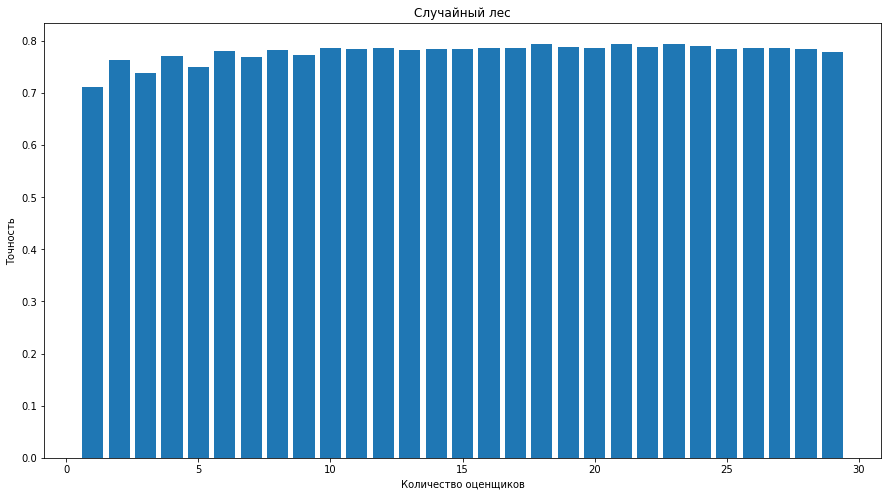

In [12]:
plt.figure(figsize=(15,8))
plt.bar(n_estimators_graph, result_draph)
plt.title('Случайный лес')
plt.xlabel("Количество оценщиков");
plt.ylabel("Точность");

Пока наилучший результат дало количество оценщиков равное 23. Дальнейшее увеличение количество оценщиков не дает результата.

Теперь проверю изменится ли точность при изменении гиперпараметров.

In [13]:
#модель без изменений
model_rfc = RandomForestClassifier(random_state=12345, n_estimators=23)
model_rfc.fit(train_behavior_features, train_behavior_target)
valid_predictions = model_rfc.predict(valid_behavior_features)
result = accuracy_score(valid_behavior_target, valid_predictions)
print('Без изменений :',result)

#изменю значение criterion на entropy
model_rfc = RandomForestClassifier(random_state=12345, n_estimators=23, criterion='entropy')
model_rfc.fit(train_behavior_features, train_behavior_target)
valid_predictions = model_rfc.predict(valid_behavior_features)
result = accuracy_score(valid_behavior_target, valid_predictions)
print('entropy :',result)

#изменю значение bootstrap на False
model_rfc = RandomForestClassifier(random_state=12345, n_estimators=23, bootstrap=False)
model_rfc.fit(train_behavior_features, train_behavior_target)
valid_predictions = model_rfc.predict(valid_behavior_features)
result = accuracy_score(valid_behavior_target, valid_predictions)
print('False :',result)

#изменю значение max_features на log2
model_rfc = RandomForestClassifier(random_state=12345, n_estimators=23, max_features='log2')
model_rfc.fit(train_behavior_features, train_behavior_target)
valid_predictions = model_rfc.predict(valid_behavior_features)
result = accuracy_score(valid_behavior_target, valid_predictions)
print('log2 :',result)

#изменю значение max_features на sqrt
model_rfc = RandomForestClassifier(random_state=12345, n_estimators=23, max_features='sqrt')
model_rfc.fit(train_behavior_features, train_behavior_target)
valid_predictions = model_rfc.predict(valid_behavior_features)
result = accuracy_score(valid_behavior_target, valid_predictions)
print('sqrt :',result)

#применю entropy и False
model_rfc = RandomForestClassifier(random_state=12345, n_estimators=23, criterion='entropy', bootstrap=False)
model_rfc.fit(train_behavior_features, train_behavior_target)
valid_predictions = model_rfc.predict(valid_behavior_features)
result = accuracy_score(valid_behavior_target, valid_predictions)
print('entropy и False :',result)

Без изменений : 0.7947122861586314
entropy : 0.7838258164852255
False : 0.7589424572317263
log2 : 0.7947122861586314
sqrt : 0.7947122861586314
entropy и False : 0.7682737169517885


Изменение гиперпараметров не дало лучшего результата.

### Логистическая регрессия

Найду лучшую модель логистической регрессии.

In [14]:
#создам списки для построения графика
iter_graph = []
accuracy_graph = []
#найду лучший результат меняя параметр max_iter
best_iter = 0
best_accuracy = 0
for max_iter in range(1,40):
    model_lr = LogisticRegression(random_state=12345, max_iter=max_iter)
    model_lr.fit(train_behavior_features, train_behavior_target)
    valid_predictions = model_lr.predict(valid_behavior_features)
    accuracy = accuracy_score(valid_behavior_target, valid_predictions)
    iter_graph.append(max_iter)
    accuracy_graph.append(accuracy)
    print('max_iter =', max_iter,':',accuracy)
    if accuracy > best_accuracy:
        best_iter, best_accuracy = max_iter, accuracy        
print(best_iter, best_accuracy)

max_iter = 1 : 0.7060653188180405
max_iter = 2 : 0.7060653188180405
max_iter = 3 : 0.7060653188180405
max_iter = 4 : 0.7060653188180405
max_iter = 5 : 0.7060653188180405
max_iter = 6 : 0.7060653188180405
max_iter = 7 : 0.7060653188180405
max_iter = 8 : 0.7060653188180405
max_iter = 9 : 0.7060653188180405
max_iter = 10 : 0.7060653188180405
max_iter = 11 : 0.7060653188180405
max_iter = 12 : 0.7060653188180405
max_iter = 13 : 0.7060653188180405
max_iter = 14 : 0.7060653188180405
max_iter = 15 : 0.7060653188180405
max_iter = 16 : 0.7060653188180405
max_iter = 17 : 0.7060653188180405
max_iter = 18 : 0.7045101088646968
max_iter = 19 : 0.7076205287713841
max_iter = 20 : 0.7076205287713841
max_iter = 21 : 0.7076205287713841
max_iter = 22 : 0.7076205287713841
max_iter = 23 : 0.7076205287713841
max_iter = 24 : 0.7076205287713841
max_iter = 25 : 0.7076205287713841
max_iter = 26 : 0.7076205287713841
max_iter = 27 : 0.7076205287713841
max_iter = 28 : 0.7076205287713841
max_iter = 29 : 0.70762052877

Построю график для визуализации.

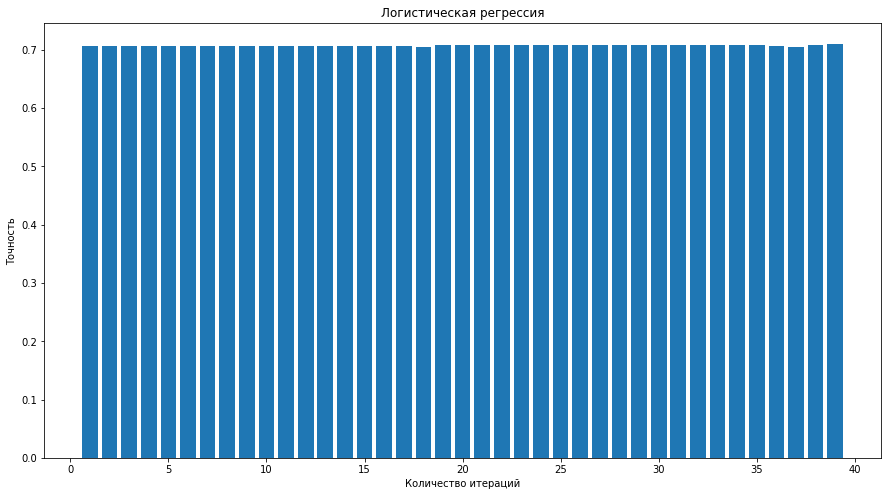

In [15]:
plt.figure(figsize=(15,8))
plt.bar(iter_graph, accuracy_graph)
plt.title('Логистическая регрессия')
plt.xlabel("Количество итераций");
plt.ylabel("Точность");

Пока наилучший результат дало количество итераций равное 29. Дальнейшее увеличение количество итераций не дает результата.

Теперь проверю изменится ли точность при изменении гиперпараметров.

In [16]:
#начну с изменения значений параметра solver
best_solver = ''
best_accuracy = 0

for solve in {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}:
    model_lr = LogisticRegression(random_state=12345, max_iter=29, solver=solve)
    model_lr.fit(train_behavior_features, train_behavior_target)
    valid_predictions = model_lr.predict(valid_behavior_features)
    accuracy = accuracy_score(valid_behavior_target, valid_predictions)
    print('Solver', solve,'Точность',accuracy)

Solver liblinear Точность 0.7573872472783826
Solver saga Точность 0.7060653188180405
Solver lbfgs Точность 0.7076205287713841
Solver newton-cg Точность 0.7558320373250389
Solver sag Точность 0.7060653188180405


Улучшений в модели нет.

In [19]:
#изменю значения параметра penalty и solver
model_lr = LogisticRegression(random_state=12345, max_iter=29, solver='saga', l1_ratio=0.5, penalty='elasticnet')
model_lr.fit(train_behavior_features, train_behavior_target)
valid_predictions = model_lr.predict(valid_behavior_features)
accuracy = accuracy_score(valid_behavior_target, valid_predictions)
print('Точность',accuracy)

Точность 0.7060653188180405


Улучшений в модели нет.

### Вывод

Наилучшие результаты для каждой модели выявились при следующих параметрах:

- для решающего древа - глубина деревьев равная 3, без изменения дополнительных параметров;
- для случайного леса - количество оценщиков равное 23, без изменения дополнительных параметров;
- для логистической регрессии - количество итераций равное 29, без изменения дополнительных параметров.

## Проверьте модель на тестовой выборке

Наилучшие модели определил, теперь проверб их работу на тестовой выборке.

In [20]:
#решающее древо
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=3)
model_dtc.fit(train_behavior_features, train_behavior_target)
test_predictions = model_dtc.predict(test_behavior_features)
result = accuracy_score(test_behavior_target,  test_predictions)
print('Точность',result)

#случайный лес
model_rfc = RandomForestClassifier(random_state=12345, n_estimators=23)
model_rfc.fit(train_behavior_features, train_behavior_target)
test_predictions = model_rfc.predict(test_behavior_features)
result = accuracy_score(test_behavior_target, test_predictions)
print('Точность',result)

#логистическая регрессия
model_lr = LogisticRegression(random_state=12345, max_iter=29)
model_lr.fit(train_behavior_features, train_behavior_target)
test_predictions = model_lr.predict(test_behavior_features)
result = accuracy_score(test_behavior_target, test_predictions)
print('Точность',result)

Точность 0.7791601866251944
Точность 0.7807153965785381
Точность 0.6936236391912908


### Вывод

Значение точности 0,75 достигли только две модели - решающее древо и случайный лес.

Наилучший результат у модели случайного леса - 0,7947.

Худший результат у модели логистической регрессии - 0,7403.

In [21]:
behavior_features = pd.concat([train_behavior_features, valid_behavior_features], ignore_index=True)
behavior_target = pd.concat([train_behavior_target, valid_behavior_target], ignore_index=True)
#решающее древо
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=3)
model_dtc.fit(behavior_features, behavior_target)
test_predictions = model_dtc.predict(test_behavior_features)
result = accuracy_score(test_behavior_target,  test_predictions)
print('Точность',result)

#случайный лес
model_rfc = RandomForestClassifier(random_state=12345, n_estimators=23)
model_rfc.fit(behavior_features, behavior_target)
test_predictions = model_rfc.predict(test_behavior_features)
result = accuracy_score(test_behavior_target, test_predictions)
print('Точность',result)

#логистическая регрессия
model_lr = LogisticRegression(random_state=12345, max_iter=29)
model_lr.fit(behavior_features, behavior_target)
test_predictions = model_lr.predict(test_behavior_features)
result = accuracy_score(test_behavior_target, test_predictions)
print('Точность',result)

Точность 0.776049766718507
Точность 0.8055987558320373
Точность 0.6905132192846034


## (бонус) Проверьте модели на адекватность

Обычно адекватность модели оценивается через обобщающую характеристику — функцию потерь. Cреднеквадратичное отклонение – самая простая функция потерь и наиболее часто используемая.

In [22]:
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=6, criterion="entropy")
model_dtc.fit(train_behavior_features, train_behavior_target)
test_predictions = model_dtc.predict(test_behavior_features)
result = mean_squared_error(test_behavior_target, test_predictions)**0.5
print("RMSE model_dtc:", result)

model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est)
model_rfc.fit(train_behavior_features, train_behavior_target)
test_predictions = model_rfc.predict(test_behavior_features)
result = mean_squared_error(test_behavior_target, test_predictions)**0.5
print("RMSE model_rfc:", result)

model_lr = LogisticRegression(random_state=12345, max_iter=29)
model_lr.fit(train_behavior_features, train_behavior_target)
test_predictions = model_lr.predict(test_behavior_features)
result = mean_squared_error(test_behavior_target, test_predictions)**0.5
print("RMSE model_lr:", result)

RMSE model_dtc: 0.46827833968854665
RMSE model_rfc: 0.46661482345519006
RMSE model_lr: 0.5535127467445616


In [23]:
from sklearn.dummy import DummyClassifier
X = behavior_features
y = behavior_target
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)
display(dummy_clf.score(X, y))

0.6958381952547646

### Вывод

Наименее адекватная модель - логистическая регрессия, со среднеквадратичным отклонением 0,5096.

Наиболее адекватная модель - случайны лес, со среднеквадратичным отклонением 0,4666.

## Общий вывод

В ходе исследования я проверил точность моделей предсказания на тестовой выборке.

Наиболее точной моделью и одновременно самой адекватной оказался случайный лес с количеством оценщиков равным 23, без изменения дополнительных параметров.

Считаю, что точности медели случайного леса (равной 79,47%) достаточно, чтобы построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».